## Лабораторная работа №3. Многомерный фильтр Калмана
**Цель работы** - спроектировать динамическую модель процесса по варианту и применить многомерный фильтр Калмана для нахождения оценок вектора состояния, а также различные метрики точности при использовании различных настроек ФК


## Теоретические сведения
Обощенная блок-схема работы многомерного фильтра Калмана для линейной динамической системы представлена на рисунке ниже

![](https://drive.google.com/uc?export=view&id=1DtxEWzOYSNlKWg2A2hJDQv-ujkfv4uIm)

## Задание лабораторной работы
1.   Написать функцию по генерации истинных значений процесса и  измерений по заданию из варианта. Сохранить истинные значения и измерения в отдельных файлах.
2.   Реализовать функцию работы многомерного Фильтра Калмана, куда можно передавать файл с истинными значениями, файл с измерениями, начальные значения вектора оценки и ковариационной матрицы, а также векторы дисперсий матриц ошибки процесса и погрешности измерений $R, Q$. Пусть погрешности элементов вектора состояния и измерения не коррелированы. Функция должна сохранять результат работы ФК в файл (вектор состояния на каждом шаге, основную диагональ матрицы ковариации, норма вектора инновации).
3.   Написать функцию, (1) реализующую последовательный запуск ФК с различными начальными параметрами. (2) Функция должна высчитывать такие метрики точности как максимальная погрешность, средняя погрешность, RMSE, а также строить график истинного значения, измерений и оценки параметра ФК с 95% доверительной границей. (3) Должен строиться график инновации.(4) Функция должна делать косвенный вывод о схождении работы ФК и времени схождения, для чего необходимо самостоятельно выбрать метрику схождения.
4.   Осуществить запуск не менее 5 наглядных конфигураций ФК, при которых фильтр может как сходиться, так и нет. Сохранить графики схождения ФК
4.   Написать вывод по работе функций и заполнить таблицу, в которой по строкам будут располагаться 5 вариантов запуска работы ФК, а по столбцам: начальные параметры запуска (перечислением), максимальная погрешность, средняя погрешность, RMSE, число итераций для схождения ФК (и заключение, если не сошелся)

7.   Написать выводы по всей работе.

## Варианты заданий
В таблице ниже представлены ссылки на описания заданий по вариантам, которые необходимо смоделировать при выполнении и сдаче лабораторной работы. Начальные значения и разброс значений выбрать самостоятельно.

| Вариант | Фамилии |
|---------|----|
| 1. [Описание варианта №1](https://colab.research.google.com/drive/1f8tDqL4yOv8G_X_IuHovsE0PxM--CaLq?usp=sharing) | Андронов, Голев, Миронов, Харламов |
| 2. [Описание варианта №2](https://colab.research.google.com/drive/1FAFiRJOIiwAZDvN93RayORONIrcKy6b_?usp=sharing) | Барыбин, Елманов, Слесарев, Чугунов |
| 3. [Описание варианта №3](https://colab.research.google.com/drive/12za9InaN3FoIGaJ6MYjIFGsiVcvS6v3B?usp=sharing) | Волков, Зинченко, Смирнов |
| 4. [Описание варианта №4](https://colab.research.google.com/drive/1iyrg0Hx2Mall04yhL_UyCq2xA7ii75Un?usp=sharing) |  Гасанов, Литвинов, Токарев |

In [506]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy

In [507]:
x_q_std = 0.0001
y_q_std = 0.0001
x_hat_q_std = 0.0001
y_hat_q_std = 0.0001
x_meas_std = 0.5
y_meas_std = 0.5

In [508]:
def generate_data(x0, y0, x_hat0, y_hat0, n):
    assert(n >= 200)

    t = np.arange(0, n)

    x_true = x0 + t * x_hat0
    y_true = y0 + t * y_hat0

    x_q = x_true + np.random.normal(0, x_q_std, len(t))
    y_q = y_true + np.random.normal(0, y_q_std, len(t))
    x_hat_q = x_hat0 + np.random.normal(0, x_hat_q_std, len(t))
    y_hat_q = y_hat0 + np.random.normal(0, y_hat_q_std, len(t))

    x_meas = x_q + np.random.normal(0, x_meas_std, len(t))
    y_meas = y_q + np.random.normal(0, y_meas_std, len(t))

    return (x_q, x_meas), (y_q, y_meas), x_hat_q, y_hat_q

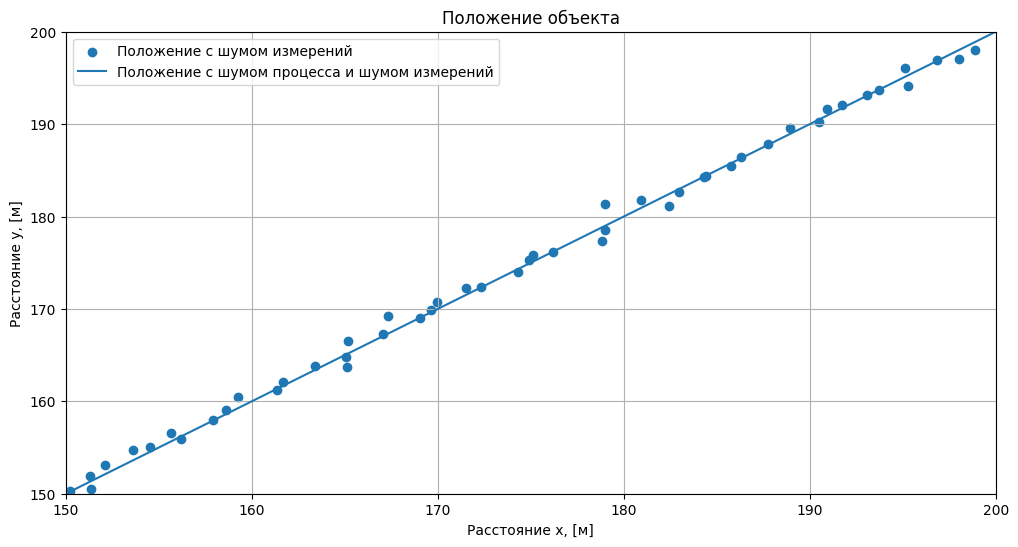

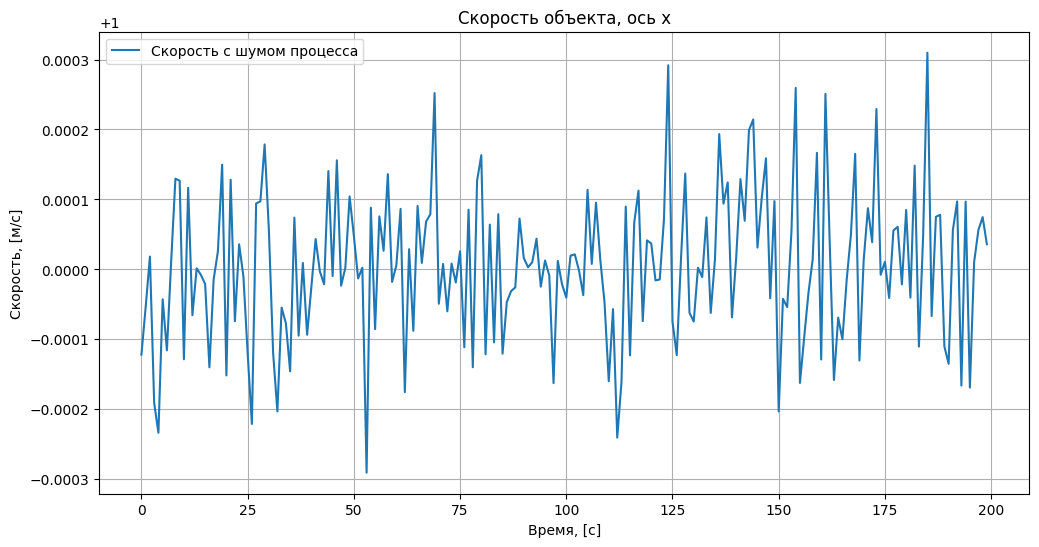

In [509]:
x0 = 10
y0 = 10
x_hat0 = 1
y_hat0 = 1
n = 200

(x_q, x_meas), (y_q, y_meas), x_hat_q, y_hat_q = generate_data(x0=x0, y0=y0, x_hat0=x_hat0,
                                                               y_hat0=y_hat0, n=n)

y_lim = (150, 200)
x_lim = (150, 200)

# Визуализация сгенерированных данных
t = range(0, n)
plt.figure(figsize=(12, 6))
plt.scatter(x_meas, y_meas, label='Положение с шумом измерений')
plt.plot(x_q, y_q, label='Положение с шумом процесса и шумом измерений')
plt.xlabel('Расстояние x, [м]')
plt.ylabel('Расстояние y, [м]')
plt.legend()
plt.grid()
plt.title(f'Положение объекта')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.show()

# Визуализация сгенерированных данных
plt.figure(figsize=(12, 6))
plt.plot(t, x_hat_q, label='Скорость с шумом процесса')
plt.xlabel('Время, [с]')
plt.ylabel('Скорость, [м/с]')
plt.legend()
plt.grid()
plt.title(f'Скорость объекта, ось x')
plt.show()


In [510]:

def kalman(z, F, R, H, P = None, x = None, B = 0, u = 0, Q = 0):

  I = np.eye(F.shape[1])

  def predict(x, P):
    return (np.dot(F, x) + np.dot(B, u),
            np.dot(np.dot(F, P), F.T) + Q)

  # Defaults
  # x = np.dot(inv(H), z[..., 0]) if x is None else x
  # P = np.dot(inv(H), np.dot(R, inv(H.T))) if P is None else P

  x, P = predict(x=x, P=P)

  x_all = []
  K_all = []
  P_all = []
  innovation_all = []

  for i in range(z.shape[1]):
    # Update
    K = np.dot(np.dot(P, H.T), inv(np.dot(H, np.dot(P, H.T)) + R))
    zi = z[..., i, None]
    innovation = zi - np.dot(H, x)
    x = x + np.dot(K, innovation)
    P = np.dot(np.dot(I - np.dot(K, H), P),
      (I - np.dot(K, H)).T) + np.dot(np.dot(K, R), K.T)

    # Outputs
    x_all.append(x)
    K_all.append(K)
    P_all.append(P)
    innovation_all.append(innovation)

    # Predict
    x, P = predict(x=x, P=P)

  return np.stack(x_all), np.stack(P_all), np.stack(K_all), np.stack(innovation_all)

In [511]:
def max_delta(measure, ref):
  return max(abs(measure - ref))

def average_delta(measure, ref):
  return 1 / len(measure) * sum(abs(measure - ref))

def rmse(measure, ref):
  return np.sqrt(1 / len(measure) * sum((measure - ref) ** 2))

In [512]:
def mean_confidence_interval(data, confidence=0.95, mean=None, std=None):
  n = len(data)
  if std  is None: std  = np.std(data, ddof=1)
  if mean is None: mean = np.mean(data)
  se = std
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return mean, mean-h, mean+h

In [513]:
def plot_pos(data_kalman_x, data_kalman_y, data_true_x, data_true_y, data_meas_x, data_meas_y,
                # conf_interval_x, conf_interval_y,
                title, should_plot_kalman_val):
  plt.figure(figsize=(12, 6))
  plt.plot(data_true_x, data_true_y, label='Истинное значение')
  plt.plot(data_meas_x, data_meas_y, 'r.', label='Измерения')
  if should_plot_kalman_val:
    plt.plot(data_kalman_x, data_kalman_y, 'g--', label='kalman_val')
  # plt.plot(data_kalman_x, conf_interval_x, color='gray', linestyle='dashed',
  #          label='Доверительный интервал')
  # plt.plot(data_kalman_y, conf_interval_y, color='gray', linestyle='dashed',
  #          label='Доверительный интервал')
  plt.ylim(y_lim)
  plt.xlim(x_lim)
  plt.xlabel('Расстояние x, [м]')
  plt.ylabel('Расстояние y, [м]')
  plt.legend()
  plt.grid()
  plt.title(title)
  plt.show()

In [514]:
def plot_vel(data_kalman, data_true,
             # conf_interval_x, conf_interval_y,
             title, should_plot_kalman_val):
  plt.figure(figsize=(12, 6))
  plt.plot(t, data_true, label='Истинное значение')
  if should_plot_kalman_val:
    plt.plot(t, data_kalman, 'g--', label='kalman_val')
  # plt.plot(data_kalman_x, conf_interval_x, color='gray', linestyle='dashed',
  #          label='Доверительный интервал')
  # plt.plot(data_kalman_y, conf_interval_y, color='gray', linestyle='dashed',
  #          label='Доверительный интервал')
  plt.xlabel('Время, [с]')
  plt.ylabel('Скорость, [м/с]')
  plt.legend()
  plt.grid()
  plt.title(title)
  plt.show()

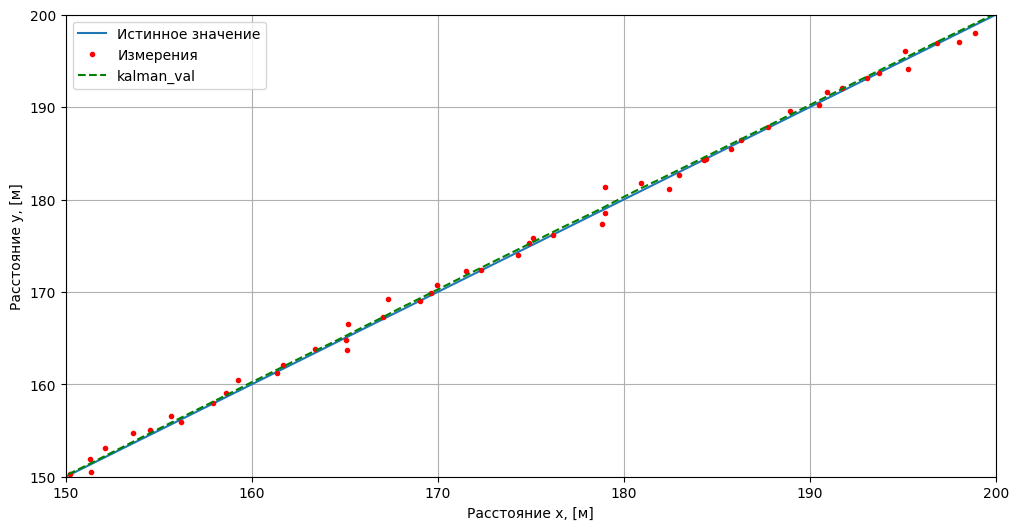

{'Δ_max': np.float64(1.8169269394733227), 'Δ_ср': np.float64(0.48864165615516914), 'Δ_rmse': np.float64(0.6318586443021786), 'n_cx': 183}


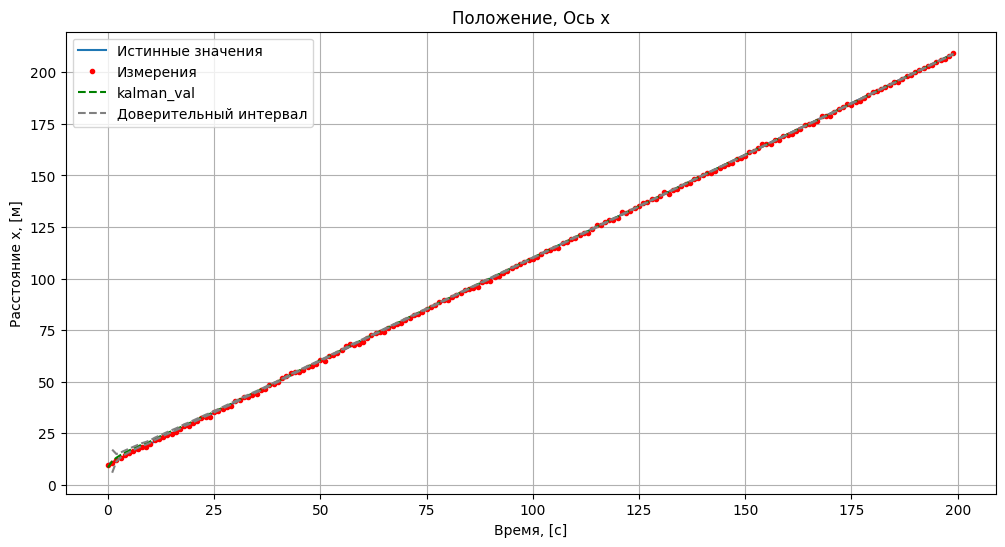

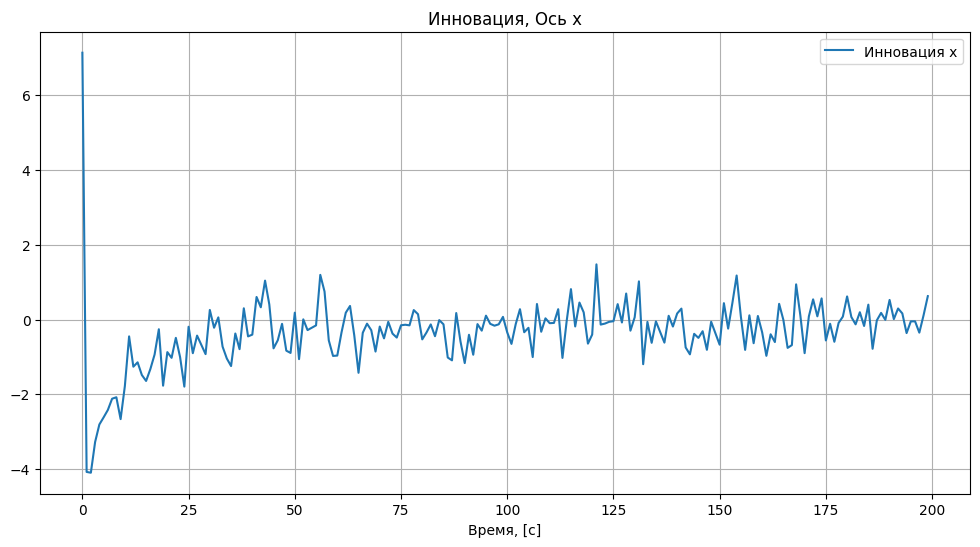

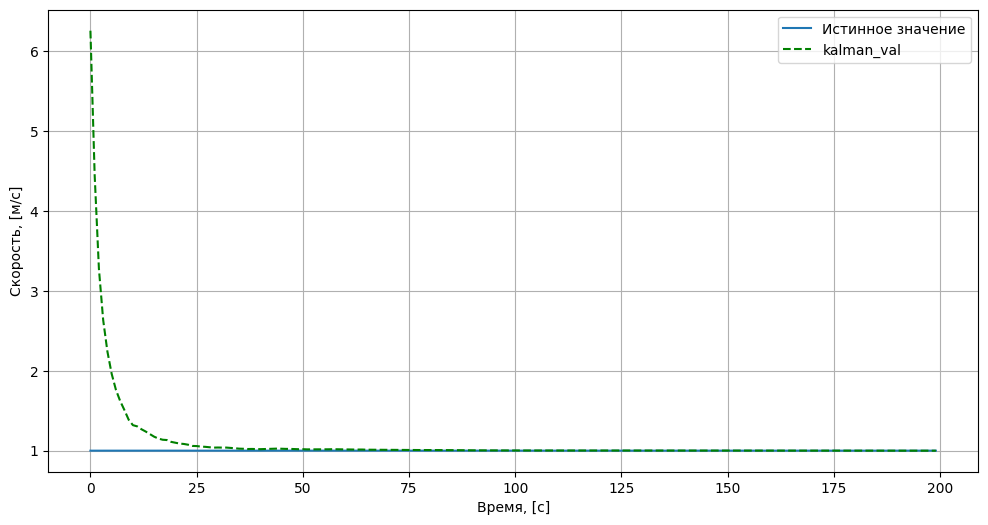

In [515]:
z = np.vstack([x_meas, y_meas])
dt = t[1] - t[0]
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1],])
R = np.array([[x_meas_std**2, 0],
              [0, y_meas_std**2]])
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
x0 = np.array([[x_hat0],
               [y_hat0],
               [1.5],
               [1.5]])
P0 = np.array([[x_meas_std**2, 0, 0, 0],
               [0, y_meas_std**2, 0, 0],
               [0, 0,             1, 0],
               [0, 0,             0, 1],])
Q  = np.array([[x_q_std**2, 0, 0, 0],
               [0, y_q_std**2, 0, 0],
               [0, 0, x_hat_q_std**2, 0],
               [0, 0, 0, y_hat_q_std**2],])

x, P, K, innovation = kalman(z=z, F=F, R=R, H=H, P=P0, x=x0, Q=Q)

conf_interval_x = []
conf_interval_y = []
for i in range(len(x)):
  data = x[:i+1, :2]
  mean = x[:i+1][-1][:2]
  std  = np.sqrt(np.array([[P[i][0, 0]], [P[i][1, 1]]]))
  _, c_l, c_r = mean_confidence_interval(data=data, confidence=0.95, mean=mean, std=std)
  conf_interval_x.append((c_l[0], c_r[0]))
  conf_interval_y.append((c_l[1], c_r[1]))

data_kalman_x = np.squeeze(x[:, 0, :])
innovation_x = np.squeeze(innovation[..., 0, :])
data_kalman_y = np.squeeze(x[:, 1, :])
data_kalman_x_hat = np.squeeze(x[:, 2, :])
data_kalman_y_hat = np.squeeze(x[:, 3, :])

plot_pos(data_kalman_x=data_kalman_x, data_kalman_y=data_kalman_y, data_true_x=x_q,
            data_true_y=y_q, data_meas_x=x_meas, data_meas_y=y_meas,
            title='', should_plot_kalman_val=True)

metrics = {
  'Δ_max': max_delta(measure=data_kalman_x, ref=z[..., 0, :]),
  'Δ_ср': average_delta(measure=data_kalman_x, ref=z[..., 0, :]),
  'Δ_rmse': rmse(measure=data_kalman_x, ref=z[..., 0, :]),
  'n_cx': len(K[np.all(K < 0.2, axis=(1, 2))]),
}
print(metrics)

plt.figure(figsize=(12, 6))
plt.plot(t, x_q, label='Истинные значения')
plt.plot(t, x_meas, 'r.', label='Измерения')
plt.plot(t, data_kalman_x, 'g--', label='kalman_val')
plt.plot(t, [el[0] for el in conf_interval_x], color='gray', linestyle='dashed',
         label='Доверительный интервал')
plt.plot(t, [el[1] for el in conf_interval_x], color='gray', linestyle='dashed')
plt.xlabel('Время, [с]')
plt.ylabel('Расстояние x, [м]')
plt.legend()
plt.grid()
plt.title('Положение, Ось x')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t, innovation_x, label='Инновация x')
plt.xlabel('Время, [с]')
plt.legend()
plt.grid()
plt.title('Инновация, Ось x')
plt.show()

plot_vel(data_kalman=data_kalman_x_hat, data_true=x_hat_q, title='', should_plot_kalman_val=True)

In [516]:
print(K[-1])
print(P[-1])

[[0.02246498 0.        ]
 [0.         0.02246498]
 [0.00022385 0.        ]
 [0.         0.00022385]]
[[5.61624394e-03 0.00000000e+00 5.59629642e-05 0.00000000e+00]
 [0.00000000e+00 5.61624394e-03 0.00000000e+00 5.59629642e-05]
 [5.59629642e-05 0.00000000e+00 1.07347057e-06 0.00000000e+00]
 [0.00000000e+00 5.59629642e-05 0.00000000e+00 1.07347057e-06]]
